# Introduction

Segmentation is the process of dividing a digital image into subsets of pixels with specific features. This can be used, for instance, to determine where specific objects are in an image, and determine their properties.

In this workshop you will use different strategies to segment biological images.

Refer to Lecture 7 for a more extended discussion.

## Semantic segmentation

We start with the problem of **semantic segmentation**. Given an image of cells, we want to determine which pixels are from cells and which are from background.

## Learning objectives

At the end of this workshop you will be able to:

- Use different thresholding strategies to perform semantic segmentation of images
- Perform instance segmentation of simple images

Complete the cell below to load and display the `cell_segm.tif` image

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

(1033, 1315, 3)


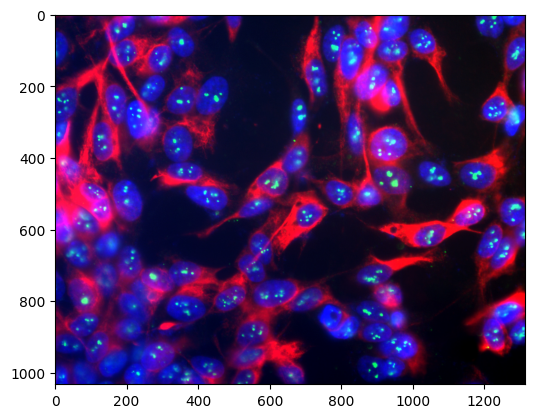

In [2]:
# Read the image
cells = plt.imread("cells_segm.tif")

# Print its shape
print(cells.shape)

# Display the image
plt.imshow(cells)
plt.show()

The image (source GerryShaw, [Wikimedia](https://commons.wikimedia.org/wiki/File:38F3-ChkNFH-DAPI-Shsy5y.jpg)) shows human SH-SY5Y cells.

Channel 0 contains staining of the cells cytoskeleton, channel 1 staining for a nucleolar protein, and channel 2 shows DNA (nuclear) staining.

We would like to determine which pixels correspond to nuclei. We would like to end up with a matrix of the same size as the original image, where each element is 1 if the pixel is in a nucleus, and 0 if it is elsewhere (cytoplasm or background)

Let's start by isolating the channel with the nuclear staining; you can use `imshow` to ensure you got the correct one!

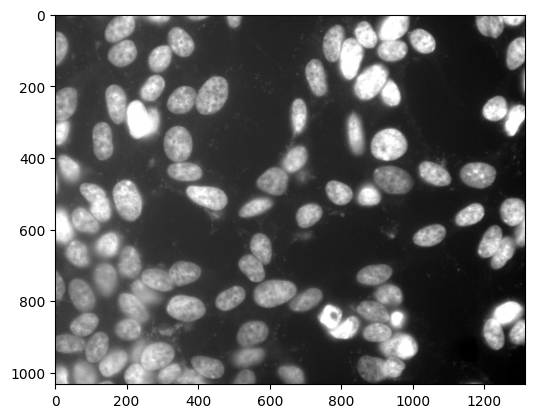

In [3]:
nuclei = cells[:, :, 2]

plt.imshow(nuclei, cmap="gray")

Let's start by plotting the image histogram to get an idea of the distribution of staining.

We would expect two peaks: one corresponding to background and one corresponding to nuclear staining.

Refer to Lecture 3 or Workshop 2 if you don't remember how to plot histograms!

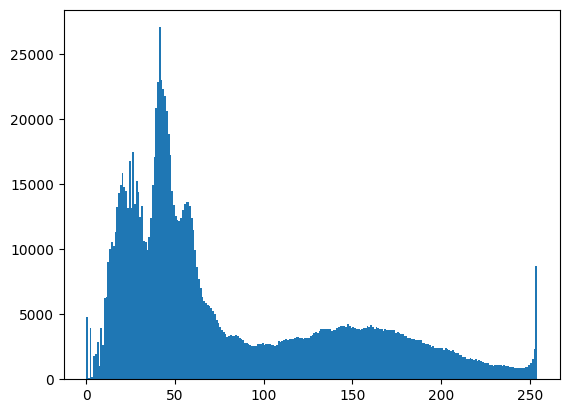

In [4]:
_ = plt.hist(nuclei.ravel(), bins=range(255))

The histogram tells us a lot! We can clearly distinguish background from nuclei, but rather than having a single background peak we get multiple ones.

**Can you explain why?**

*ANSWER*: it looks like the cytoplasm is also very lightly stained (likely due to autofluorescence, or non-specific staining), so we get multiple peaks in the background.

We can now try to manually choose a threshold to separate nuclei from background.

**Use the histogram to try and find the value that best separates background from nuclei.**

You can try a few values and get a feeling for the one that visually gives the same result.

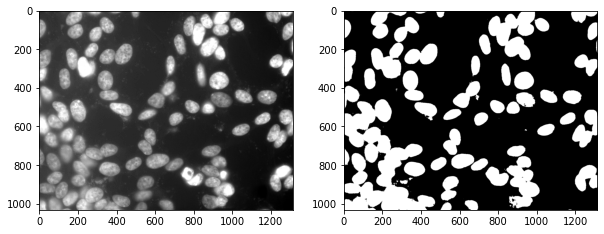

In [8]:
nuclei_threshold_manual = nuclei>95

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))

ax[0].imshow(nuclei, cmap="gray")
ax[1].imshow(nuclei_threshold_manual, cmap="gray")

plt.show()

Let's say you now want to determine what percentage of the image is occupied by cell nuclei?

**How would you do that?**

<details>
    <summary style="cursor: pointer;">Click here to reveal a hint.</summary>
    You can use the Numpy function `unique` with the `return_counts` parameter set to `True`. 
    
    What does this function return? How can it help in answering the question above?
</details>

In [9]:
values, counts = np.unique(nuclei_threshold_manual, return_counts=True)
print(f"Percentage of image covered by nuclei is {counts[1]/(counts[0]+counts[1])*100:.2f}%")

Percentage of image covered by nuclei is 33.28%


As we saw in the lecture, there are better, more automatable, ways to determine an optimal threshold.

Scikit Image provides several methods, which are imported below. 

- Apply the different methods to the image
- Note that you have to specify the `block_size` parameter for `threshold_local` (and it MUST be an odd number). What happens if the block size is too small?
- Visually compare the results of the various methods, including the manual thresholding
- Calculate the percentage of pixels containing nuclei in the image in the various cases
- Is there anything that stand out? How good was your manual threshold compared to the automatic methods?


Otsu - percentage of image covered by nuclei is 30.91%
Li - percentage of image covered by nuclei is 34.64%
Local - percentage of image covered by nuclei is 32.19%


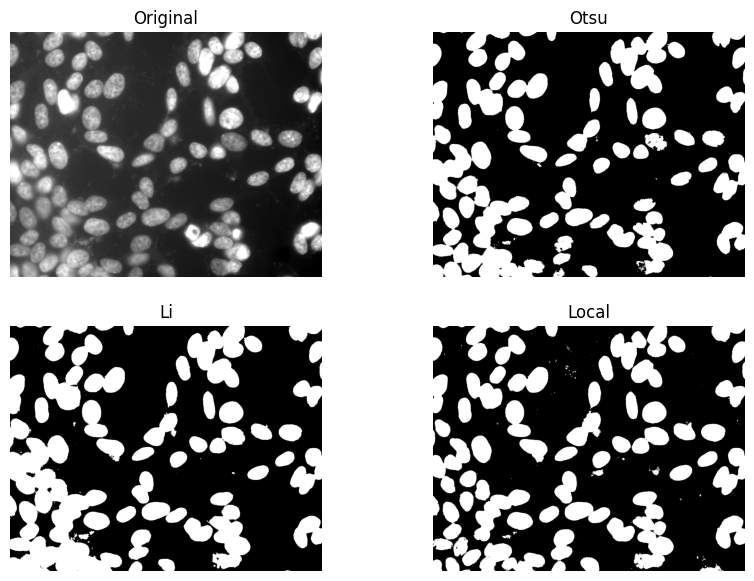

In [7]:
from skimage.filters import threshold_otsu, threshold_li, threshold_local

nuclei_threshold_otsu = nuclei > threshold_otsu(nuclei)
nuclei_threshold_li = nuclei > threshold_li(nuclei)
nuclei_threshold_local = nuclei > threshold_local(nuclei, block_size=399)

# Now show the images
fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10, 7))
ax[0, 0].imshow(nuclei, cmap="gray")
ax[0, 1].imshow(nuclei_threshold_otsu, cmap="gray")
ax[1, 0].imshow(nuclei_threshold_li, cmap="gray")
ax[1, 1].imshow(nuclei_threshold_local, cmap="gray")

titles = ["Original", "Otsu", "Li", "Local"]

for i, a in enumerate(ax.ravel()):
    a.axis("off")
    a.set_title(titles[i])
def get_cell_area(image):
    values, counts = np.unique(image, return_counts=True)
    return counts[1]/(counts[0]+counts[1])*100

print(f"Otsu - percentage of image covered by nuclei is {get_cell_area(nuclei_threshold_otsu):.2f}%")
print(f"Li - percentage of image covered by nuclei is {get_cell_area(nuclei_threshold_li):.2f}%")
print(f"Local - percentage of image covered by nuclei is {get_cell_area(nuclei_threshold_local):.2f}%")

Remember that you can use morphological operations, including opening and closing, removing small objects or filling small holes to remove noise in your masks. Give it a try!

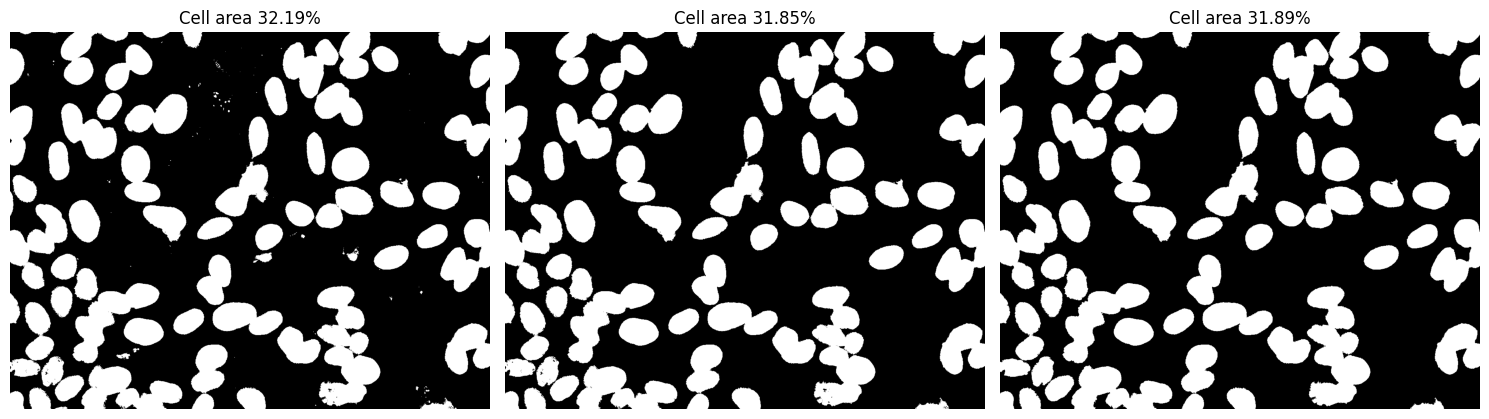

In [9]:
from skimage.morphology import remove_small_objects, remove_small_holes

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15, 5))

thr_local_no_small = remove_small_objects(nuclei_threshold_local, min_size=1000)
thr_local_no_small_no_holes = remove_small_holes(thr_local_no_small, area_threshold = 100)

area = []
ax[0].imshow(nuclei_threshold_local, cmap="gray")
area.append(get_cell_area(nuclei_threshold_local))
ax[1].imshow(thr_local_no_small, cmap="gray")
area.append(get_cell_area(thr_local_no_small))
ax[2].imshow(thr_local_no_small_no_holes, cmap="gray")
area.append(get_cell_area(thr_local_no_small_no_holes))

for i, a in enumerate(ax):
    a.axis("off")
    a.set_title(f"Cell area {area[i]:.2f}%")

plt.tight_layout()

## Instance segmentation

Instance segmentation is definitely a harder problem to solve.
For each pixel, not only we want to define whether it is in a nucleus, but also which nucleus it is in!

This will allow us to make cell-level measurements, a very useful tool for analysis of biological images! 

We are going to cover one of the _traditional_ methods, a technique called *watershed* (refer to the lecture on segmentation for more details!). 
There are more sophisticated methods for instance segmentation, we will see some of them later on in the course!

The main idea of watershed is to first create a binary mask of our image, as we did above, then identify the center of each cell and use that as a _seed_ to divide the mask into instances.

Let’s see how to do it with Scikit Image!

Use the [distance_transform_edt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html) function to find the distance of each pixel of the image mask from the background. Visualize the result to better understand what is going on! You can use whichever mask gave you the best results in the previous part.

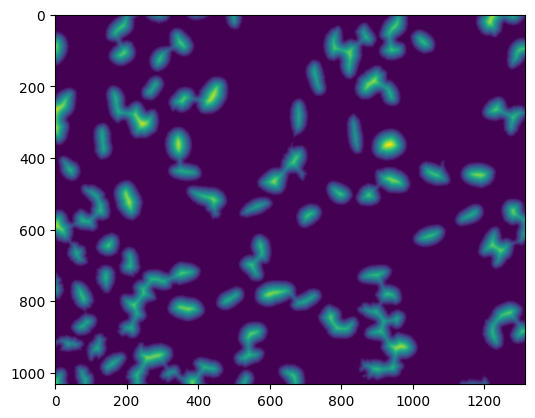

In [10]:
from scipy.ndimage import distance_transform_edt

best_mask = thr_local_no_small_no_holes

distance = distance_transform_edt(best_mask)

plt.imshow(distance)

You can see how the center of (almost all) cells is brighter. 

We will now proceed to the watershed, by using three functions.

- [peak_local_max](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max) to retrieve the local maxima corresponding to the centers of each cell in our distance function.
- [label](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label), to label connected regions with the same values.
- [watershed](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed), to perform watershed segmentation and divide touching nuclei. 

In [11]:
from skimage.feature import peak_local_max
from skimage.measure import label
from skimage.segmentation import watershed

# Find the local maxima of the distance map.
# We need to impose a minimum distance between the peaks and we can specify 
# a "footprint" to search for local maxima. You can experiment with these value to find
# one that works best with your image
# peak_local_max returns the indices of the maxima
local_maxima_idx = peak_local_max(distance, min_distance=30,
               footprint=np.ones((5, 5)))
# We create a matrix of "False" with the same shape of the image
mask = np.zeros(distance.shape, dtype=bool)
# We now mark the maxima as True (note that we need to transpose the matrix)
mask[tuple(local_maxima_idx.T)] = True

# Label connected regions
markers = label(mask)
# Split touching nuclei using watershed
segmented = watershed(-distance, markers, mask=best_mask)

The segmented image will have each pixel marked with an integer (1,2,3,...) corresponding to the nucleus it belongs to. If you show it using a "normal" colourmap it may be difficult to distinguish between closeby nuclei. We will create a random colourmap to avoid this problem.

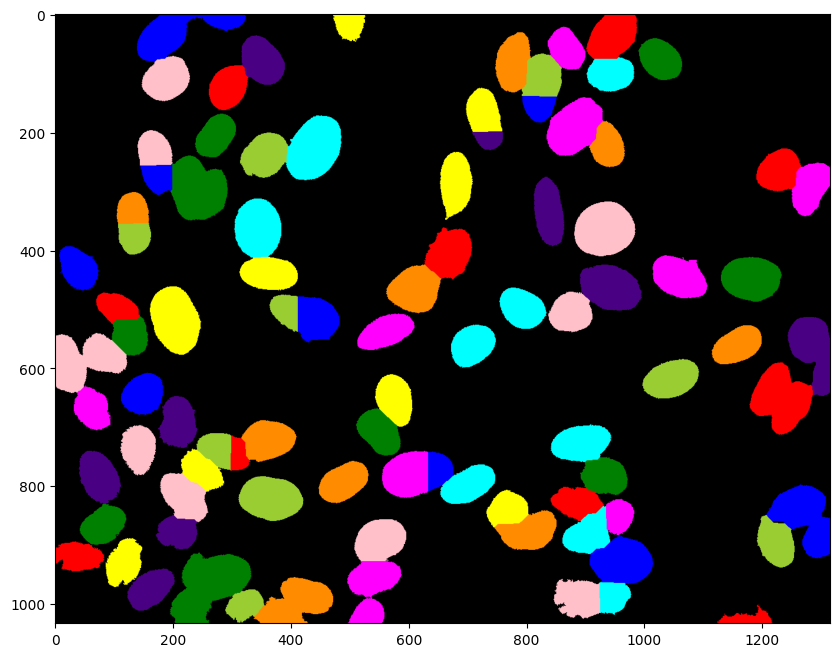

In [13]:
# Use label2rgb to help visualize the results
from skimage.color import label2rgb
segmented = remove_small_objects(segmented, min_size=1000)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.imshow(label2rgb(segmented, bg_label=0)) 
plt.show()

There are a few things you may want to try to improve segmentation

- Try different parameters for `peak_local_max`
- Some initial filtering or denoising may help in some cases
- Small objects in the segmentation can still be removed using morphological operations! 


## Challenge!

Create a Python program that, given an image similar to the one used in this workshop, segments it and plots the distribution of the area of the nuclei.

You should be able to call it as something like

`python segmentation.py -input image.tif`

Try adding other parameters, such as initial filtering, type of threshold etc.

For example `python segmentation.py -input image.tif -filter median -threshold local -output segmented.tif`

_Sorry... no solution given for this... give it a try and post your results on Slack, you have all the necessary knowledge to do this!!!_ 😁